# Step 1: Loading the Dataset:

## Library Imports

In this code block, we import three essential Python libraries for data analysis and visualization:

In [71]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mstats

## Downloading and Extracting ZIP File

In this section, we download a ZIP file from a Google Drive link and extract its contents for further use.


In [72]:
f_zip = 'https://drive.google.com/uc?id=1BEw0yn43diJnfWajfB10M8TMsi3XmMem'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

## Loading the main Excel File with Multiple Sheets and Saving as CSVs

In [73]:

# Load the Excel file
xls = pd.ExcelFile("food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")

# Create the target folder if it doesn't exist
folder_path = "./resources"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Iterate over each sheet in the Excel file and save as a separate CSV file in the target folder
for sheet in xls.sheet_names:
    if sheet != "Title Page":  # Exclude the "Title Page" sheet
        df = xls.parse(sheet)
        csv_filename = sheet.replace(" ", "_") + ".csv"  # Convert spaces to underscores for the filename
        save_path = os.path.join(folder_path, csv_filename)
        df.to_csv(save_path, index=False)


## Extracting and Splitting the CropStats DataFrame

In this section, we focus on the "CropStats" dataframe from the Excel file and perform the following tasks:

. **Splitting the DataFrame by Crop Type:**
   - We identify unique crop types in the "crop" column.
   - For each unique crop type, we create a subset of the dataframe.
   - We construct a CSV filename for each crop type by replacing spaces with underscores and appending ".csv."

. **Saving Crop Data as Separate CSV Files:**
   - We save each crop-specific subset as a separate CSV file in the "resources/crop stats" folder using `df.to_csv()`.
   - The CSV files are named based on the crop type.


In [74]:
# Extract the CropStats dataframe
crop_path = './resources/crop stats'
if not os.path.exists(crop_path):
    os.makedirs(crop_path)

# Re-read the CropStats dataframe
cropstats_df = pd.read_excel('food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx', sheet_name="CropStats")

# Split the dataframe based on the 'crop' column and save to separate files
unique_crops = cropstats_df['crop'].unique()
saved_crop_files = []

for crop in unique_crops:
    filtered_df = cropstats_df[cropstats_df['crop'] == crop]
    file_path = f"resources/crop stats/CropStats_{crop.replace(' ', '_')}.csv"
    filtered_df.to_csv(file_path, index=False)
    saved_crop_files.append(file_path)

saved_crop_files

['resources/crop stats/CropStats_wheat.csv',
 'resources/crop stats/CropStats_maize.csv',
 'resources/crop stats/CropStats_spring_wheat.csv',
 'resources/crop stats/CropStats_winter_wheat.csv',
 'resources/crop stats/CropStats_cereals.csv']

# Step 2: Data exploration


## 1. Initial Data Inspection for Cereals

  - We load the Cereals dataset from the CSV file and inspect the data types of its columns.


In [75]:
# Convert 'Harvest_year' to a datetime format
cropstats_cereals_df = pd.read_csv('resources/crop stats/CropStats_cereals.csv')
# Inspect the data types of the columns in the df_cropstats DataFrame
cropstats_cereals_df.dtypes



Unnamed: 0               int64
Harvest_year             int64
admin0                  object
admin1                 float64
crop                    object
hectares (ha)          float64
production (tonnes)    float64
year                     int64
yield(tonnes/ha)       float64
admin2                 float64
notes                  float64
dtype: object

In [76]:
cropstats_cereals_df.describe()

,Unnamed: 0,Harvest_year,admin1,hectares (ha),production (tonnes),year,yield(tonnes/ha),admin2,notes
count,80.0000,80.0000,0.0,8.000000e+01,8.000000e+01,80.0000,80.000000,0.0,0.0
mean,29571.5000,1977.5000,NaN,2.446386e+06,2.908026e+06,1977.5000,0.961218,NaN,NaN
std,23.2379,23.2379,NaN,2.608322e+06,3.601824e+06,23.2379,0.406611,NaN,NaN
min,29532.0000,1938.0000,NaN,2.718000e+03,5.079000e+02,1938.0000,0.150000,NaN,NaN
25%,29551.7500,1957.7500,NaN,4.331750e+03,3.306625e+03,1957.7500,0.677500,NaN,NaN
50%,29571.5000,1977.5000,NaN,4.798500e+03,5.484750e+03,1977.5000,0.880000,NaN,NaN
75%,29591.2500,1997.2500,NaN,5.172690e+06,5.311454e+06,1997.2500,1.134200,NaN,NaN
max,29611.0000,2017.0000,NaN,6.081400e+06,1.168910e+07,2017.0000,2.140700,NaN,NaN


The descriptive statistics provide insights into the distribution of the numeric columns in the `cropstats_cereals_df` DataFrame. For instance:

- The `Harvest_year` and `year` columns span from 1938 to 2017.
- The mean `yield (tonnes/ha)` is approximately 0.961, with a minimum of 0.150 and a maximum of 2.141.

We check for missing values within the dataset and report the count of missing values for each column.


In [77]:
# Check for missing values in the dataset
missing_values = cropstats_cereals_df.isnull().sum()
missing_values


Unnamed: 0              0
Harvest_year            0
admin0                  0
admin1                 80
crop                    0
hectares (ha)           0
production (tonnes)     0
year                    0
yield(tonnes/ha)        0
admin2                 80
notes                  80
dtype: int64

- Missing Values:
  - The 'admin1', 'admin2', and 'notes' columns contain 80 missing values each.


# Step 3: Data cleaning

In this section, we perform data cleaning on the dataset, we start with:

**Converting 'Harvest_year':**
   - We converted the 'Harvest_year' column to a datetime format and extracted the year.

**Column Removal:**
   - We identified and dropped the following redundant or empty columns:
     - 'Unnamed: 0'
     - 'year'
     - 'admin1'
     - 'admin2'
     - 'notes'
     - 'crop'

**Column Renaming:**
   - We renamed the 'admin0' column to 'country' for clarity.

In [78]:
#converting
cropstats_cereals_df['Harvest_year'] = pd.to_datetime(cropstats_cereals_df['Harvest_year'], format = '%Y').dt.year

# Drop redundant or completely empty columns
columns_to_drop = ['Unnamed: 0', 'year', 'admin1', 'admin2', 'notes', 'crop']
cropstats_cereals_df = cropstats_cereals_df.drop(columns=columns_to_drop)

# Rename 'admin0' to 'country'
cropstats_cereals_df = cropstats_cereals_df.rename(columns={'admin0': 'country'})

# Display the dataframe
cropstats_cereals_df.head()

,Harvest_year,country,hectares (ha),production (tonnes),yield(tonnes/ha)
0,1938,Morocco,3596.0,2046.6,0.57
1,1939,Morocco,4141.0,3841.9,0.93
2,1940,Morocco,4466.0,2998.8,0.67
3,1941,Morocco,4466.0,3950.9,0.88
4,1942,Morocco,4331.0,3432.5,0.79


**Duplicates Check:**

In [79]:
# Check for duplicated rows
duplicated_rows = cropstats_cereals_df[cropstats_cereals_df.duplicated()]

duplicated_rows

,Harvest_year,country,hectares (ha),production (tonnes),yield(tonnes/ha)


**Missing Values:**

In [80]:
# Check for missing values in the dataset
missing_values = cropstats_cereals_df.isnull().sum()
missing_values

Harvest_year           0
country                0
hectares (ha)          0
production (tonnes)    0
yield(tonnes/ha)       0
dtype: int64

# Step 3: EDA

##  1. Visualizing Cereal Yield Over Time by Country

The line plot below displays the cereal yield (in tonnes per hectare) over time for various countries. Each line represents a different country, and the x-axis represents the year, while the y-axis shows the yield.

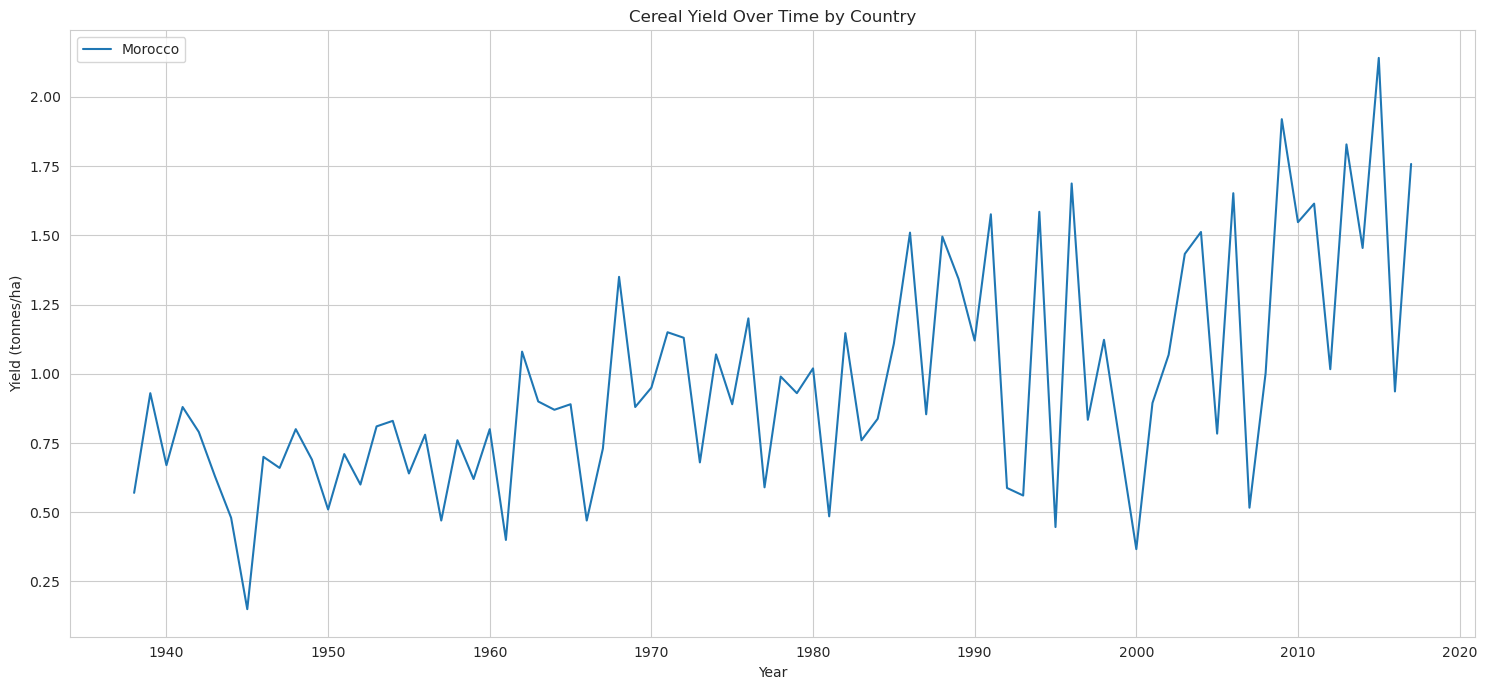

In [81]:

# Plotting yield over time for cereals
plt.figure(figsize=(15, 7))
for country in cropstats_cereals_df['country'].unique():
    country_data = cropstats_cereals_df[cropstats_cereals_df['country']  == country]
    plt.plot(country_data['Harvest_year'], country_data['yield(tonnes/ha)'], label=country)

plt.title("Cereal Yield Over Time by Country")
plt.xlabel("Year")
plt.ylabel("Yield (tonnes/ha)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Insights:**

- There seems to be a general upward trend in the cereal yield over the years.
- There are noticeable dips in certain years, which could be attributed to various factors such as droughts, pests, or economic challenges.
- The period around the 1980s shows some inconsistency or fluctuation in yield. This could be an interesting point for further investigation.

## 2. Identifying Outliars:

To identify outliers, we'll start by visualizing the distribution of the numeric columns. This will give us a sense of where potential outliers might be. We'll use boxplots for this purpose, as they are particularly good at highlighting outliers in the data.

Let's create boxplots for the columns `hectares (ha)`, `production (tonnes)`, and `yield(tonnes/ha)`.

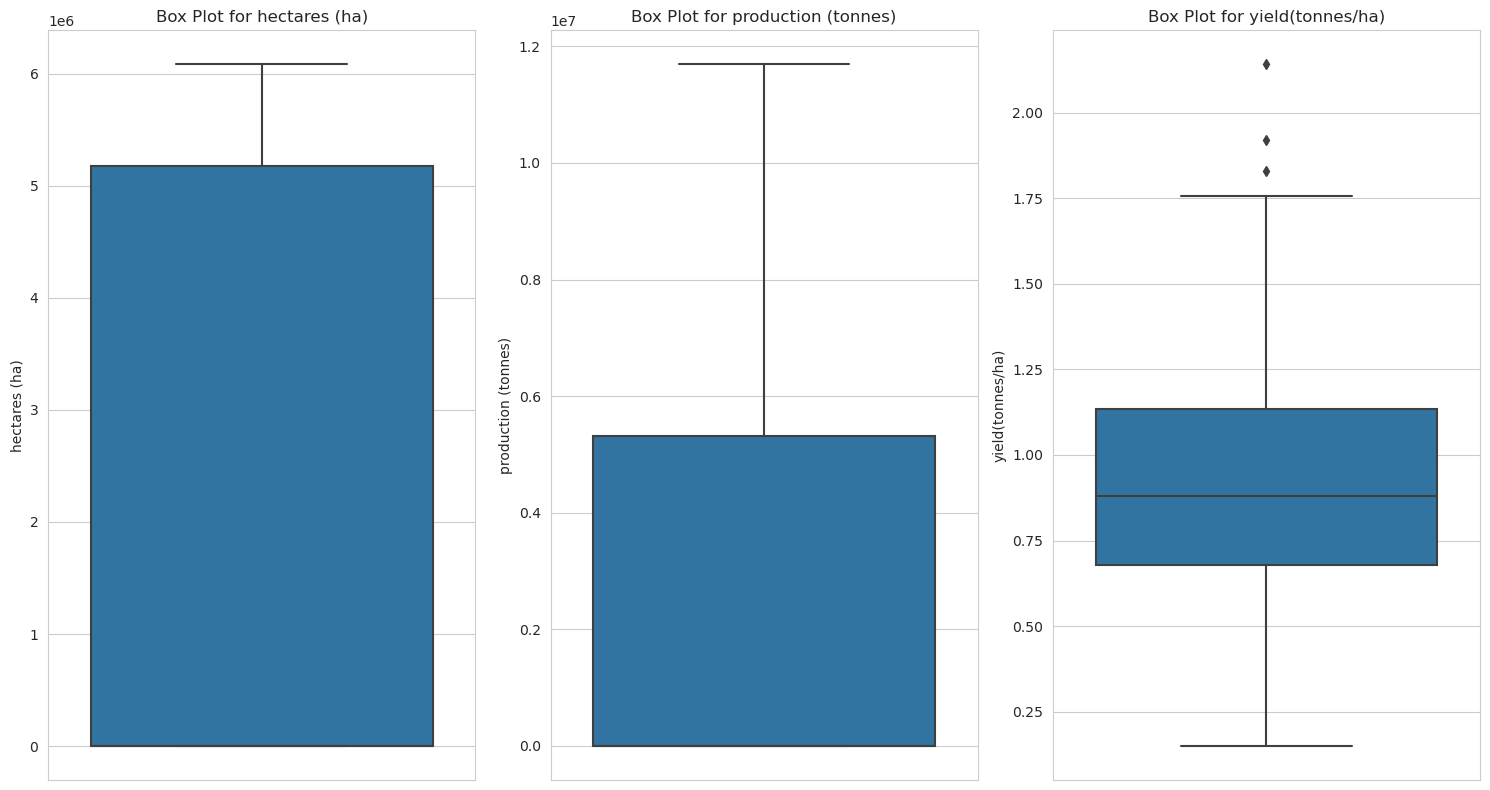

In [82]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Define the columns for which we want to detect outliers
columns_to_check = ['hectares (ha)', 'production (tonnes)', 'yield(tonnes/ha)']

# Plot box plots for each column to detect outliers
plt.figure(figsize=(15, 8))

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=cropstats_cereals_df[col])
    plt.title(f'Box Plot for {col}')
    plt.ylabel(col)
    plt.xlabel('')

plt.tight_layout()
plt.show()

**Insights:**

- The `hectares (ha)` and `production (tonnes)` columns appear to have some data points that are significantly higher than the rest, suggesting potential outliers.
- The `yield(tonnes/ha)` column seems fairly consistent, with a few potential outliers on the higher side.

## 3. Identifying Outliers Using the IQR Method

To quantitatively identify outliers in the dataset, we applied the **Interquartile Range (IQR) method**, a widely used technique for outlier detection. According to this method, values that fall below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR are considered outliers.

Let's calculate the IQR for each of these columns and identify the outliers based on this criterion.

In [83]:
# Calculate IQR for each numeric column and identify outliers
outliers = {}

numeric_cols = ['hectares (ha)', 'production (tonnes)', 'yield(tonnes/ha)']

for col in numeric_cols:
    Q1 = cropstats_cereals_df[col].quantile(0.25)
    Q3 = cropstats_cereals_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify and store outliers
    outliers[col] = cropstats_cereals_df[(cropstats_cereals_df[col] < lower_bound) | (cropstats_cereals_df[col] > upper_bound)]

# Return the number of outliers for each column
outliers_counts = {col: len(outliers[col]) for col in numeric_cols}
outliers_counts

{'hectares (ha)': 0, 'production (tonnes)': 0, 'yield(tonnes/ha)': 3}

Based on the Interquartile Range (IQR) method:

- For `hectares (ha)`: There are no outliers.
- For `production (tonnes)`: There are no outliers.
- For `yield(tonnes/ha)`: There are 3 outliers.

It's interesting to note that while the boxplots for `hectares (ha)` and `production (tonnes)` suggested potential outliers, the IQR method did not flag any values as outliers for these columns. This discrepancy highlights the importance of using multiple methods or visualizations when assessing outliers, as different approaches may yield different results.

Now, let's take a closer look at the specific data points identified as outliers for `yield(tonnes/ha)`.

## 4. Investigating Outliers in 'Yield (tonnes/ha)'


In [84]:
# Display the outliers for 'yield(tonnes/ha)'
outliers['yield(tonnes/ha)']

,Harvest_year,country,hectares (ha),production (tonnes),yield(tonnes/ha)
71,2009,Morocco,5441176.0,10443719.0,1.9194
75,2013,Morocco,5401005.0,9874543.0,1.8283
77,2015,Morocco,5460480.0,11689100.0,2.1407


In our analysis, we identified three outliers in the 'Yield (tonnes/ha)' column. These outliers are as follows:

1. In the year 2009, Morocco reported an exceptionally high yield of 1.9194 tonnes/ha.
2. In 2013, Morocco recorded a similarly high yield of 1.8283 tonnes/ha.
3. In 2015, Morocco reported an extraordinarily high yield of 2.1407 tonnes/ha.

The presence of these outliers may be attributed to specific factors or unique circumstances in those years, such as exceptional weather conditions, advanced agricultural practices, or data reporting anomalies. Investigating the underlying reasons for these outliers and considering whether to retain or adjust them in the analysis is a crucial next step.

## 5. Outlier Removal Using Modified Z-Score

Let's try a different method to detect outliars, Modified Z-Score Method which uses the median and the median absolute deviation (MAD) to detect outliers. This method can be more robust against outliers compared to the traditional Z-score method that relies on the mean and standard deviation.


Typically, a Modified Z-Score above 3.5 in absolute value is considered to indicate an outlier.

Let's compute the Modified Z-Scores for the columns hectares (ha) and production (tonnes) and identify potential outliers.

In [85]:
def modified_z_score(series):
    """Calculate modified Z-scores based on Median and MAD."""
    median = series.median()
    mad = abs(series - median).median()
    return 0.6745 * (series - median) / mad

# Calculate Modified Z-scores for 'hectares (ha)' and 'production (tonnes)' columns
cropstats_cereals_df['mod_z_score_hectares'] = modified_z_score(cropstats_cereals_df['hectares (ha)'])
cropstats_cereals_df['mod_z_score_production'] = modified_z_score(cropstats_cereals_df['production (tonnes)'])

# Identify data points with Modified Z-scores greater than 3.5 (or less than -3.5) as outliers for both columns
mod_z_outliers_hectares = cropstats_cereals_df[abs(cropstats_cereals_df['mod_z_score_hectares']) > 3.5]
mod_z_outliers_production = cropstats_cereals_df[abs(cropstats_cereals_df['mod_z_score_production']) > 3.5]

# Return the outliers based on Modified Z-score method for both columns
mod_z_outliers_hectares[['Harvest_year', 'hectares (ha)', 'mod_z_score_hectares']], mod_z_outliers_production[['Harvest_year', 'production (tonnes)', 'mod_z_score_production']]

(    Harvest_year  hectares (ha)  mod_z_score_hectares
 42          1980      4428550.0           2027.051893
 43          1981      4391000.0           2009.845728
 44          1982      4287300.0           1962.328303
 45          1983      4712100.0           2156.980205
 46          1984      4488300.0           2054.430545
 47          1985      4792400.0           2193.775280
 48          1986      5182870.0           2372.696486
 49          1987      5080200.0           2325.651027
 50          1988      5322300.0           2436.586115
 51          1989      5531900.0           2532.629050
 52          1990      5603328.0           2565.358796
 53          1991      5498300.0           2517.232854
 54          1992      5020280.0           2298.194478
 55          1993      5027863.0           2301.669161
 56          1994      6081400.0           2784.421000
 57          1995      3993575.0           1827.737601
 58          1996      5988285.0           2741.753834
 59       

Using the Modified Z-Score method:

For `hectares (ha)`:

 - Multiple outliers were detected, starting from the year 1980 and continuing onward. These values have significantly higher Modified Z-Scores.

For `production (tonnes)`:

 - Several outliers were detected, mostly in the latter years. These values also have significantly higher Modified Z-Scores.


## 6. Visualizing Shift in 'hectares (ha)' and 'production (tonnes)' Over Time

To gain a better understanding of the shift in 'hectares (ha)' and 'production (tonnes)' over the years, we've plotted these trends and identified a structural change.


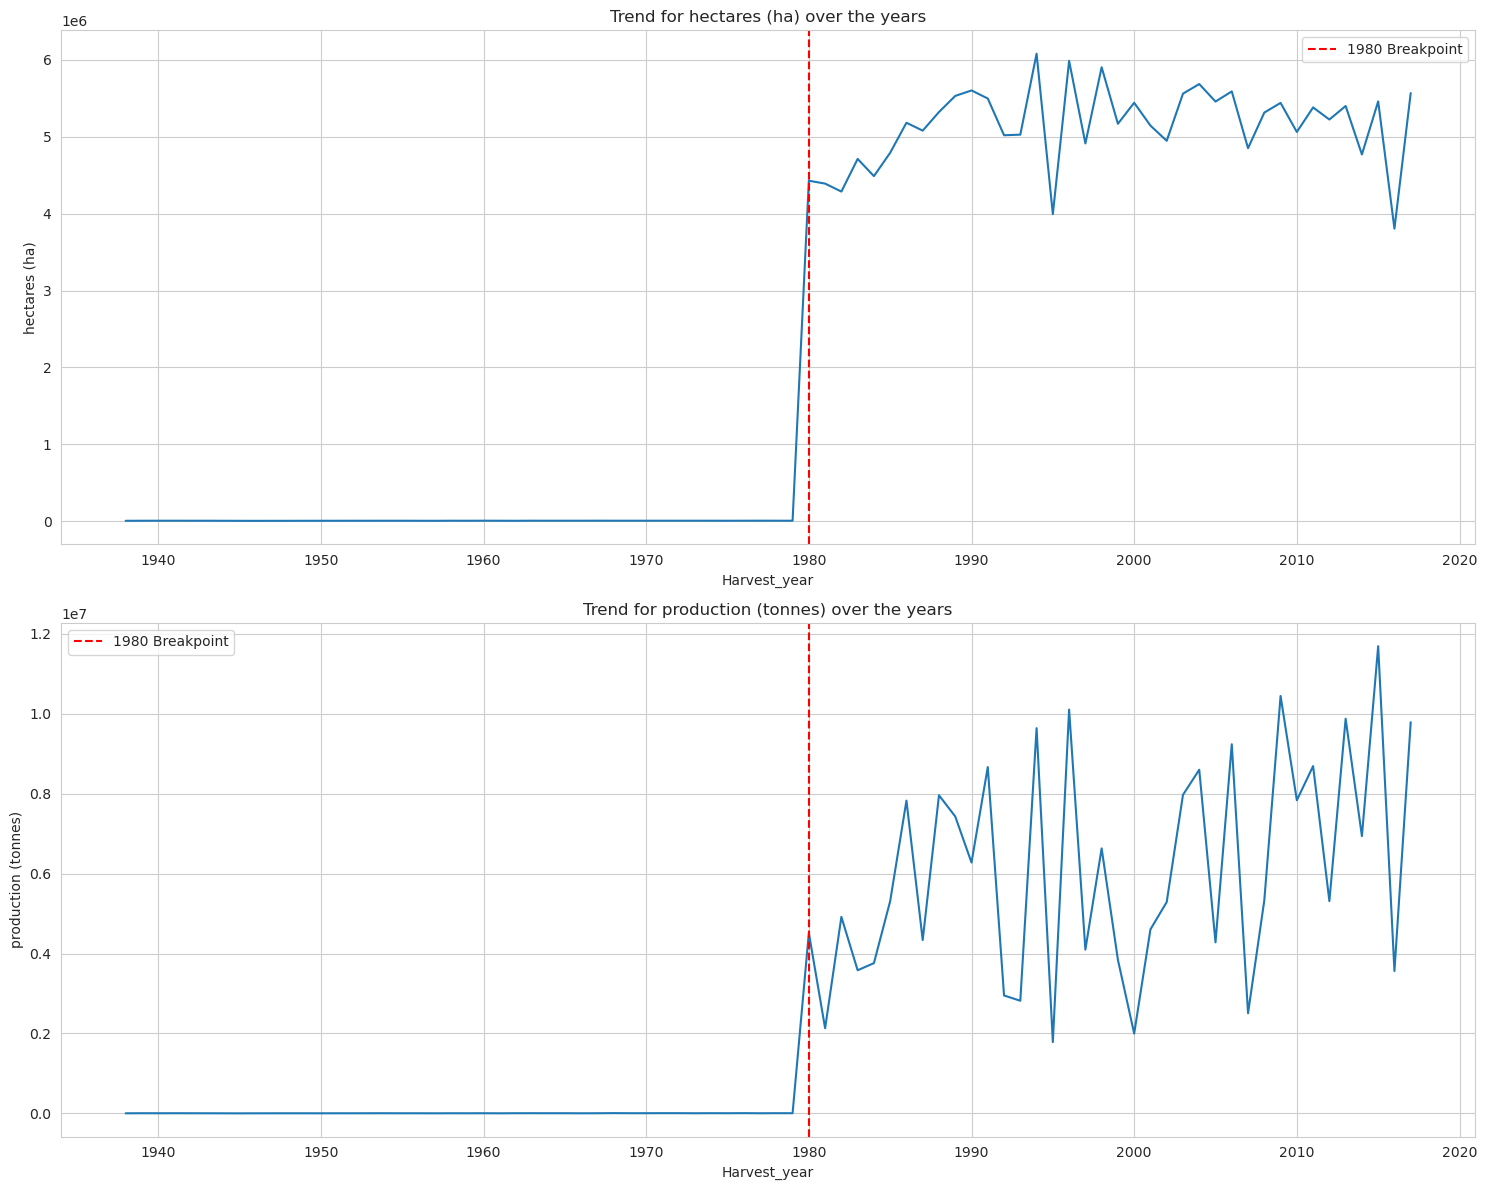

In [86]:
# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Plot data for 'hectares (ha)' and 'production (tonnes)' over the years
sns.lineplot(x=cropstats_cereals_df['Harvest_year'], y=cropstats_cereals_df['hectares (ha)'], ax=ax[0])
ax[0].axvline(1980, color='red', linestyle='--', label="1980 Breakpoint")
ax[0].set_title('Trend for hectares (ha) over the years')
ax[0].legend()

sns.lineplot(x=cropstats_cereals_df['Harvest_year'], y=cropstats_cereals_df['production (tonnes)'], ax=ax[1])
ax[1].axvline(1980, color='red', linestyle='--', label="1980 Breakpoint")
ax[1].set_title('Trend for production (tonnes) over the years')
ax[1].legend()

# Adjust the layout
plt.tight_layout()
plt.show()

The visualizations clearly illustrate a structural change.

Given this insight, when analyzing the data for outliers or any other statistical properties, it would be prudent to segment the data into two periods: before 1980 and from 1980 onward. Each segment can then be treated separately, allowing for a more nuanced understanding and handling of the data.



- **Trend for hectares (ha) over the years:** The plot shows a significant structural change occurring around the year 1980, marked by a vertical red dashed line. Before 1980, 'hectares (ha)' exhibit a different pattern compared to the years following 1980. The structural change is evident in the data.

- **Trend for production (tonnes) over the years:** Similar to 'hectares (ha),' the production trend also reflects a noticeable shift around 1980. This structural change is highlighted by the red dashed line.

The structural change observed in these two agricultural metrics is a crucial insight. When analyzing the data for outliers or other statistical characteristics, segmenting it into two periods—before and after 1980—would be a prudent approach. This separation allows for a more nuanced understanding and treatment of the data.

Additionally, if the relationship between production and hectares (i.e., the yield) remains consistent over time, including data from before 1980 can provide the model with more samples to learn this relationship. The yield, serving as a normalized metric, captures the efficiency or productivity of land use. Consistency in yield patterns across both periods suggests that underlying factors impacting yield, such as agricultural practices, soil quality, and climate conditions, may have remained relatively stable.


## 8. Analyzing Yield (Production per Hectare) Over Time

Let's visualize the yield (production/ha) over time to understand if its patterns have remained consistent across the two periods.


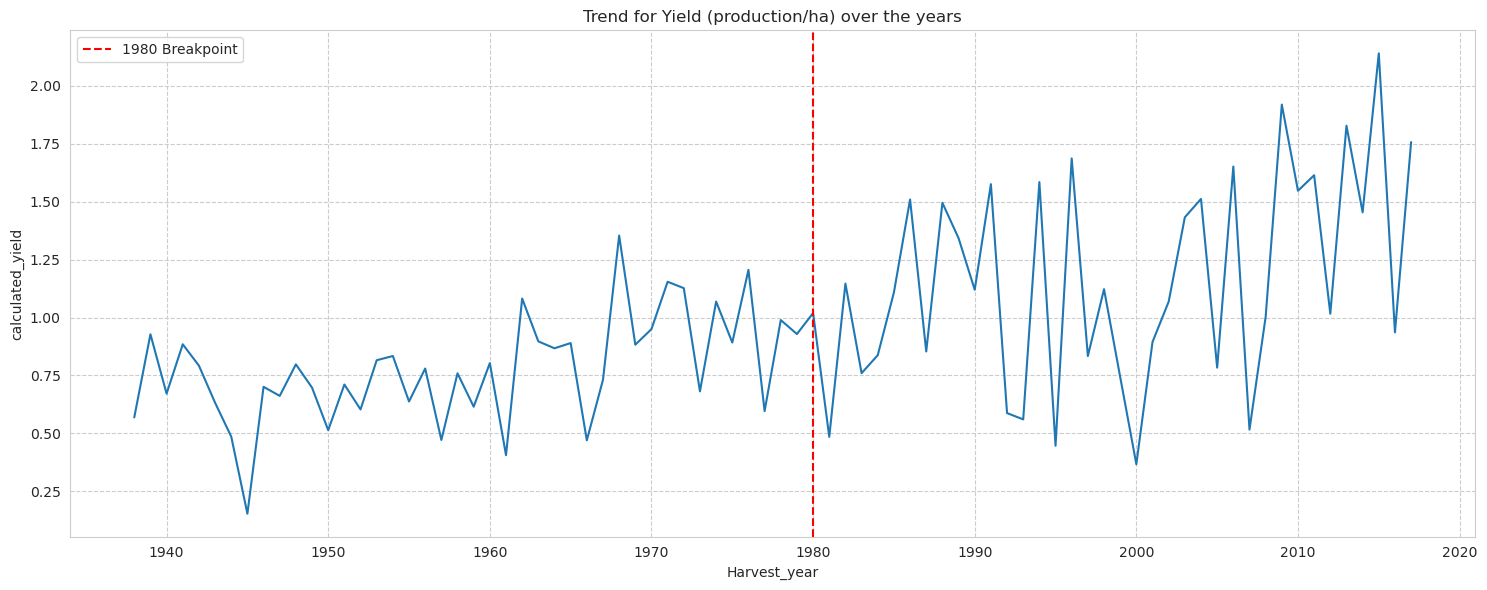

In [87]:
# Calculate yield as production per hectare
cropstats_cereals_df['calculated_yield'] = cropstats_cereals_df['production (tonnes)'] / cropstats_cereals_df['hectares (ha)']

# Plot yield over the years
plt.figure(figsize=(15, 6))
sns.lineplot(x=cropstats_cereals_df['Harvest_year'], y=cropstats_cereals_df['calculated_yield'])
plt.axvline(1980, color='red', linestyle='--', label="1980 Breakpoint")
plt.title('Trend for Yield (production/ha) over the years')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

In this visual analysis, we've examined the trend for yield, represented as production per hectare (production/ha), over the years. Our goal is to determine whether yield patterns have remained consistent across the two distinct periods (before and after 1980).

Key observations from the visualization:

- **Yield Trend:** The line plot illustrates the yield trend over time, showing fluctuations but no pronounced structural shift around 1980.

This visualization supports the notion that the underlying relationship or efficiency of production remained relatively consistent over the two periods. It is particularly relevant if our forecasting model focuses on yield or if yield is a significant feature in our model. In such cases, the entire dataset (both pre-1980 and post-1980) could provide valuable insights since yield patterns exhibit consistency over time.

However, if the forecasting model primarily targets individual metrics such as production or hectares, segmenting the data might still be considered, taking into account the structural break observed in 1980 for these metrics.

In summary, including data from before 1980 can be valuable for the model to learn the consistent relationship between production and hectares (yield) when that relationship is the primary focus.


## 9. Winsorization of Yield (Production per Hectare)

In this step, we explore the process of winsorization as a technique to manage the influence of outliers in the 'yield (tonnes/ha)' column. Winsorization involves limiting extreme values by replacing them with less extreme values, thereby reducing their impact on statistical analysis while retaining the data points.


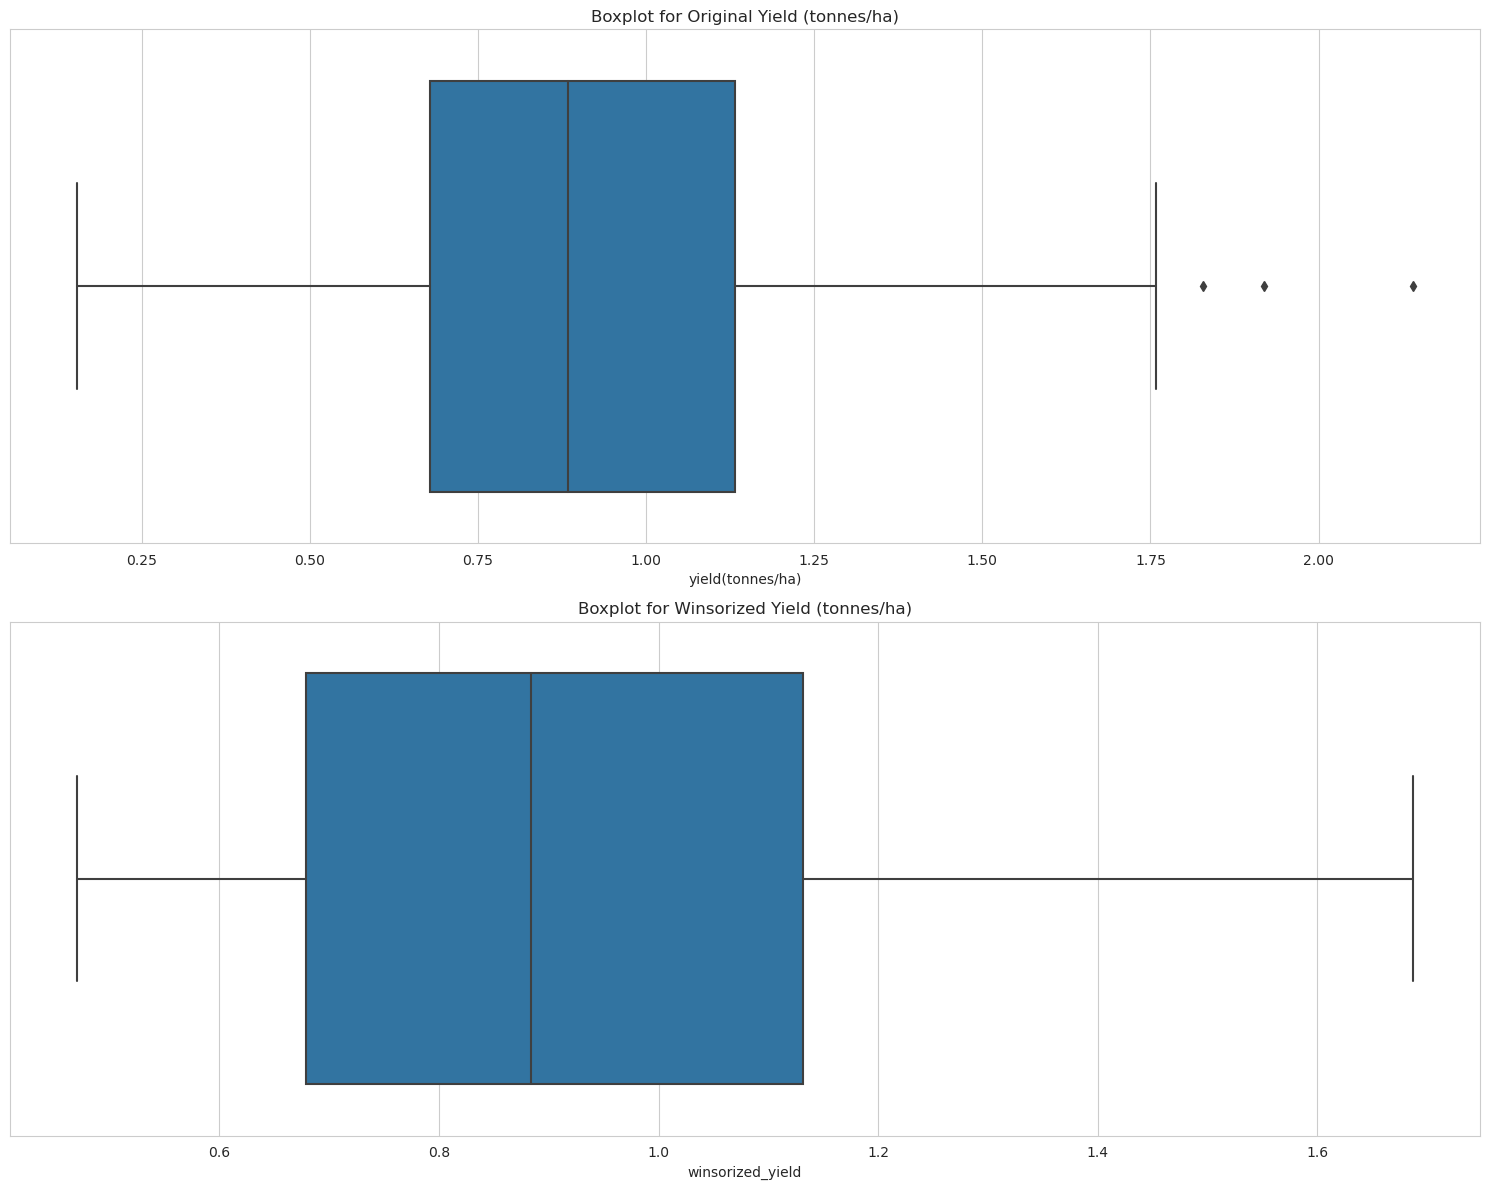

In [88]:

# Calculate yield as production per hectare
cropstats_cereals_df['yield(tonnes/ha)'] = cropstats_cereals_df['production (tonnes)'] / cropstats_cereals_df['hectares (ha)']

# Winsorize the 'yield(tonnes/ha)' column at the 5th and 95th percentiles
cropstats_cereals_df['winsorized_yield'] = mstats.winsorize(cropstats_cereals_df['yield(tonnes/ha)'], limits=[0.05, 0.05])

# Visualize the original and winsorized yield values
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Original yield values
sns.boxplot(x=cropstats_cereals_df['yield(tonnes/ha)'], ax=ax[0])
ax[0].set_title('Boxplot for Original Yield (tonnes/ha)')

# Winsorized yield values
sns.boxplot(x=cropstats_cereals_df['winsorized_yield'], ax=ax[1])
ax[1].set_title('Boxplot for Winsorized Yield (tonnes/ha)')

plt.tight_layout()
plt.show()



Key points of the winsorization process:

- **Calculate Yield:** First, we calculate 'yield (tonnes/ha)' by dividing 'production (tonnes)' by 'hectares (ha)'.

- **Winsorization:** We apply winsorization to the 'yield (tonnes/ha)' column, limiting extreme values at the 5th and 95th percentiles. This process replaces extreme values with values closer to the 5th and 95th percentiles.

- **Boxplot Comparison:** To visualize the effect of winsorization, we create boxplots for the original 'yield (tonnes/ha)' values and the winsorized 'yield' values.

**Boxplot Comparison:**

- *Original Yield Values:* The first boxplot displays the distribution of the original 'yield (tonnes/ha)' values. It shows the presence of outliers as indicated by the points beyond the whiskers.

- *Winsorized Yield Values:* The second boxplot represents the distribution of the 'winsorized_yield' values after applying the winsorization technique. The boxplot illustrates that extreme outliers have been replaced by values closer to the 5th and 95th percentiles, which effectively reduces their influence.

The use of winsorization is particularly helpful when we believe that the outliers represent genuine data points but have a disproportionate impact. It allows us to manage their influence without completely discarding the data. In this specific case, the boxplot shows that the 'winsorized_yield' values have a narrower distribution with extreme outliers mitigated.


## 10. Data distribution

Analyzing the distribution of the target variable is crucial when building predictive models, as certain algorithms assume that the input features and/or target variable follow a normal (or at least symmetric) distribution.

Let's start by visualizing the distribution of the production (tonnes) column using a boxplot. This will give us an idea of its skewness. If the distribution appears to be skewed, we can consider applying transformations to make it more symmetric.

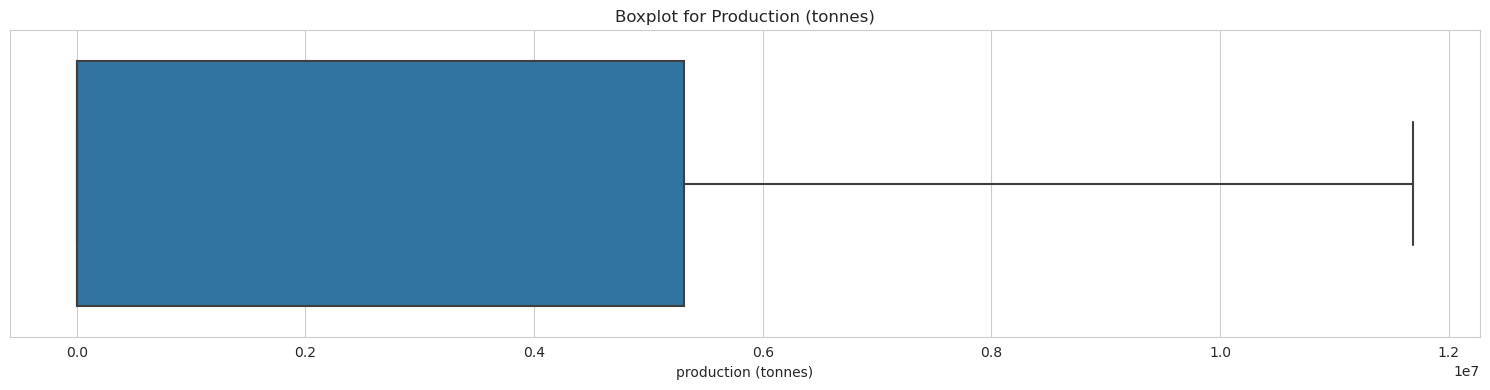

In [89]:
# Set up the figure and axes
plt.figure(figsize=(15, 4))



# Boxplot for 'production (tonnes)'
sns.boxplot(x=cropstats_cereals_df['production (tonnes)'])
plt.title('Boxplot for Production (tonnes)')

plt.tight_layout()
plt.show()

The visualizations provide insights into the distribution of the production (tonnes) column:

The distribution appears right-skewed, with a tail extending towards the higher values. There's a clear peak near the lower values, with fewer data points as the production increases.

The boxplot confirms the skewness, with many data points above the upper whisker that can be considered outliers.

Given this right-skewed distribution, applying a transformation can help make the data more symmetric. One common transformation for right-skewed data is the logarithmic transformation. It compresses the higher values more than the lower values, potentially making the distribution more symmetric.

Let's apply a logarithmic transformation to the production (tonnes) column and visualize the resulting distribution.

## 10. Logarithmic Transformation of Production (tonnes)

In this step, we explore the application of a logarithmic transformation to the 'production (tonnes)' column. A logarithmic transformation is often used to stabilize the variance and make the data conform more closely to a normal distribution. This is particularly useful when the data exhibits heteroscedasticity or when we want to emphasize relative changes rather than absolute values.


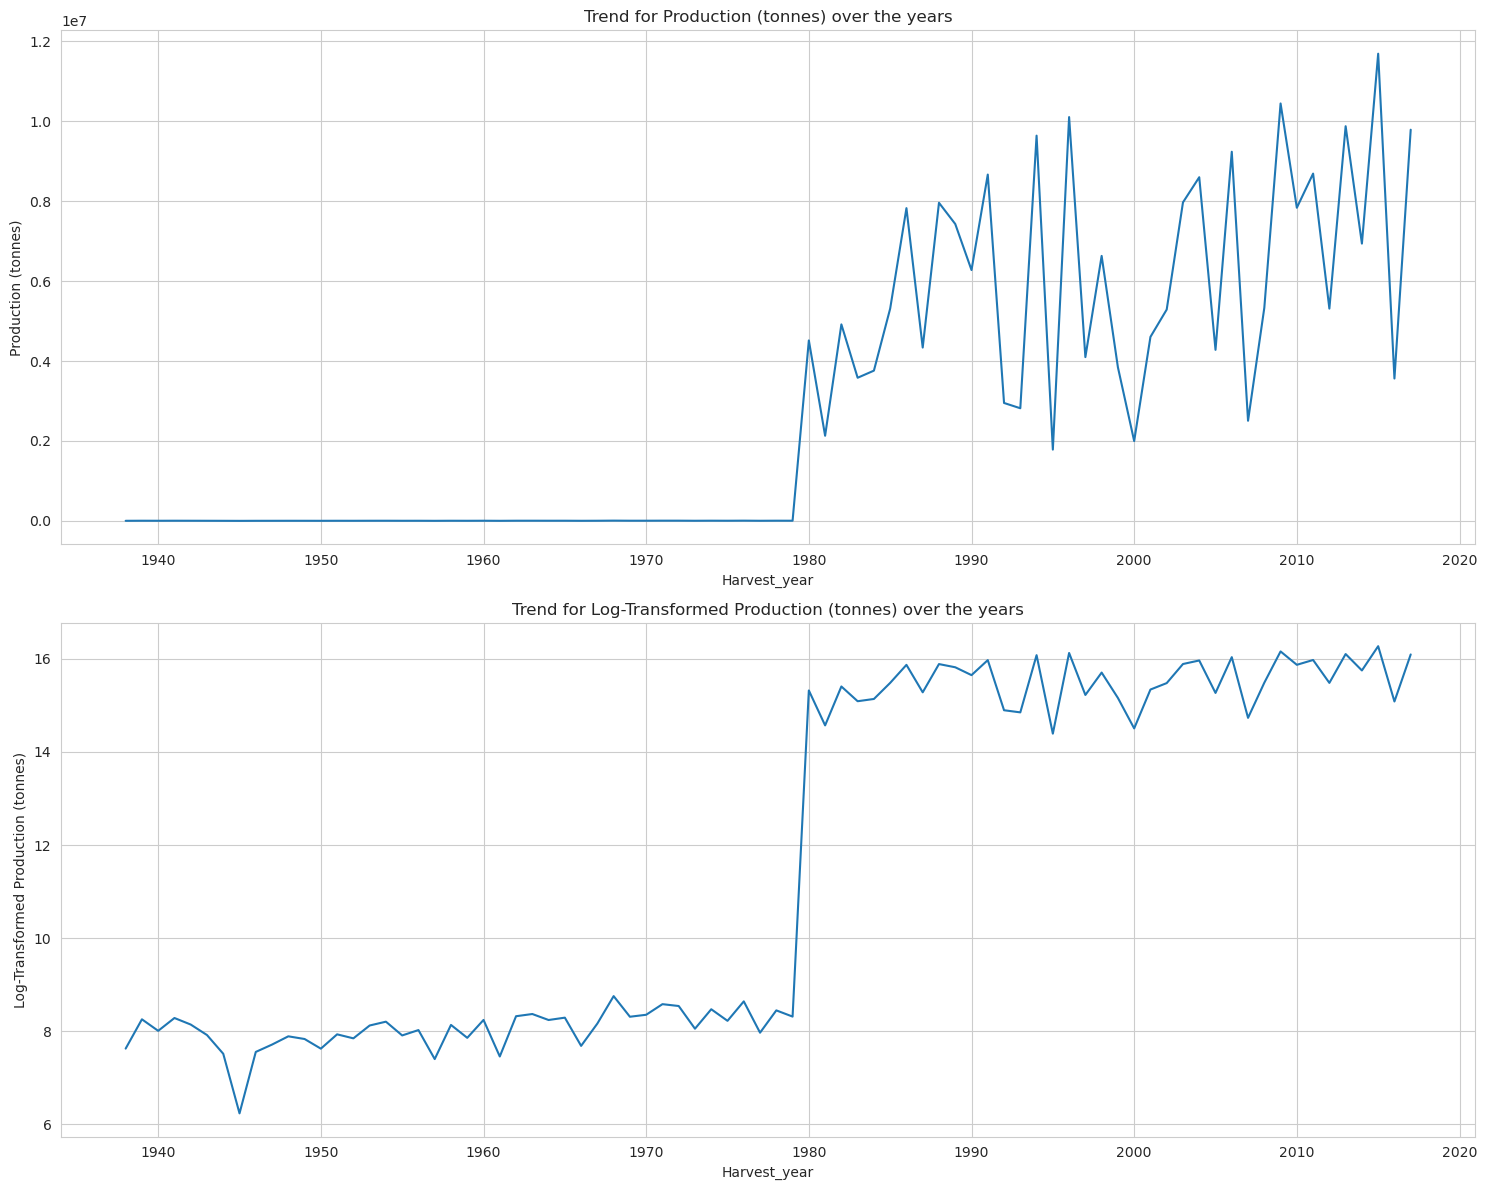

In [90]:
# Apply logarithmic transformation (adding a small constant to handle zeros)

cropstats_cereals_df['log_production'] = np.log(cropstats_cereals_df['production (tonnes)'] + 1)
# Set up the figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Line chart for 'production (tonnes)' per year
sns.lineplot(x=cropstats_cereals_df['Harvest_year'], y=cropstats_cereals_df['production (tonnes)'], ax=ax[0])
ax[0].set_title('Trend for Production (tonnes) over the years')
ax[0].set_ylabel('Production (tonnes)')

# Line chart for log-transformed 'production (tonnes)' per year
sns.lineplot(x=cropstats_cereals_df['Harvest_year'], y=cropstats_cereals_df['log_production'], ax=ax[1])
ax[1].set_title('Trend for Log-Transformed Production (tonnes) over the years')
ax[1].set_ylabel('Log-Transformed Production (tonnes)')

plt.tight_layout()
plt.show()


The visualizations depict the trends for `production (tonnes)` and log-transformed` production (tonnes)` over the years:

**Top Chart (Production over Years)**: This line chart showcases the trend for production (tonnes) over the years. As observed earlier, there's a noticeable increase around 1980, followed by some fluctuations.

**Bottom Chart (Log-Transformed Production over Years)**: This line chart presents the trend for the log-transformed `production (tonnes)` over the years. The transformation compresses the scale, making it easier to observe variations over time. The general trend remains, but the increase around 1980 appears smoother, and the fluctuations in later years are more discernible.

Using the log-transformed data can sometimes offer clearer insights into the underlying patterns, especially when the original data spans a wide range.

## 11. Segmenting Data and Detecting Outliers in Log(Production)

let's segment the data into two subsets based on the year 1980:

- Pre-1980 Data: Data from the beginning up to the year 1979.
- Post-1980 Data: Data from the year 1980 onward.

After segmenting the data, we'll check for outliers in the log(production) values for each subset using the IQR method

In [91]:
# Segment data into pre-1980 and post-1980 subsets
pre_1980_data = cropstats_cereals_df[cropstats_cereals_df['Harvest_year'] < 1980]
post_1980_data = cropstats_cereals_df[cropstats_cereals_df['Harvest_year'] >= 1980]

# Function to compute IQR bounds for outlier detection
def compute_iqr_bounds(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Compute IQR bounds for pre-1980 data
pre_1980_lower_bound, pre_1980_upper_bound = compute_iqr_bounds(pre_1980_data['log_production'])

# Compute IQR bounds for post-1980 data
post_1980_lower_bound, post_1980_upper_bound = compute_iqr_bounds(post_1980_data['log_production'])

# Identify outliers in pre-1980 data based on IQR method
pre_1980_outliers = pre_1980_data[(pre_1980_data['log_production'] < pre_1980_lower_bound) | 
                                  (pre_1980_data['log_production'] > pre_1980_upper_bound)]

# Identify outliers in post-1980 data based on IQR method
post_1980_outliers = post_1980_data[(post_1980_data['log_production'] < post_1980_lower_bound) | 
                                    (post_1980_data['log_production'] > post_1980_upper_bound)]

pre_1980_outliers[['Harvest_year', 'log_production']], post_1980_outliers[['Harvest_year', 'log_production']]

(   Harvest_year  log_production
 7          1945        6.232252,
 Empty DataFrame
 Columns: [Harvest_year, log_production]
 Index: [])

After segmenting the data and checking for outliers in the `log(production)` values using the IQR method:

**For the Pre-1980 Data**:

One outlier was detected in the year 1945 with a log(production) value of approximately 6.232.

**For the Post-1980 Data**:

No outliers were detected based on the IQR method.

## 12. Winsorization of Log(Production) Values

In this step, we apply winsorization to the log(production) values, specifically targeting the outlier detected in the Pre-1980 Data (in the year 1945). Winsorization caps the extreme values at specified percentiles (in this case, the 5th and 95th percentiles), effectively reducing their influence on the dataset without completely removing them.

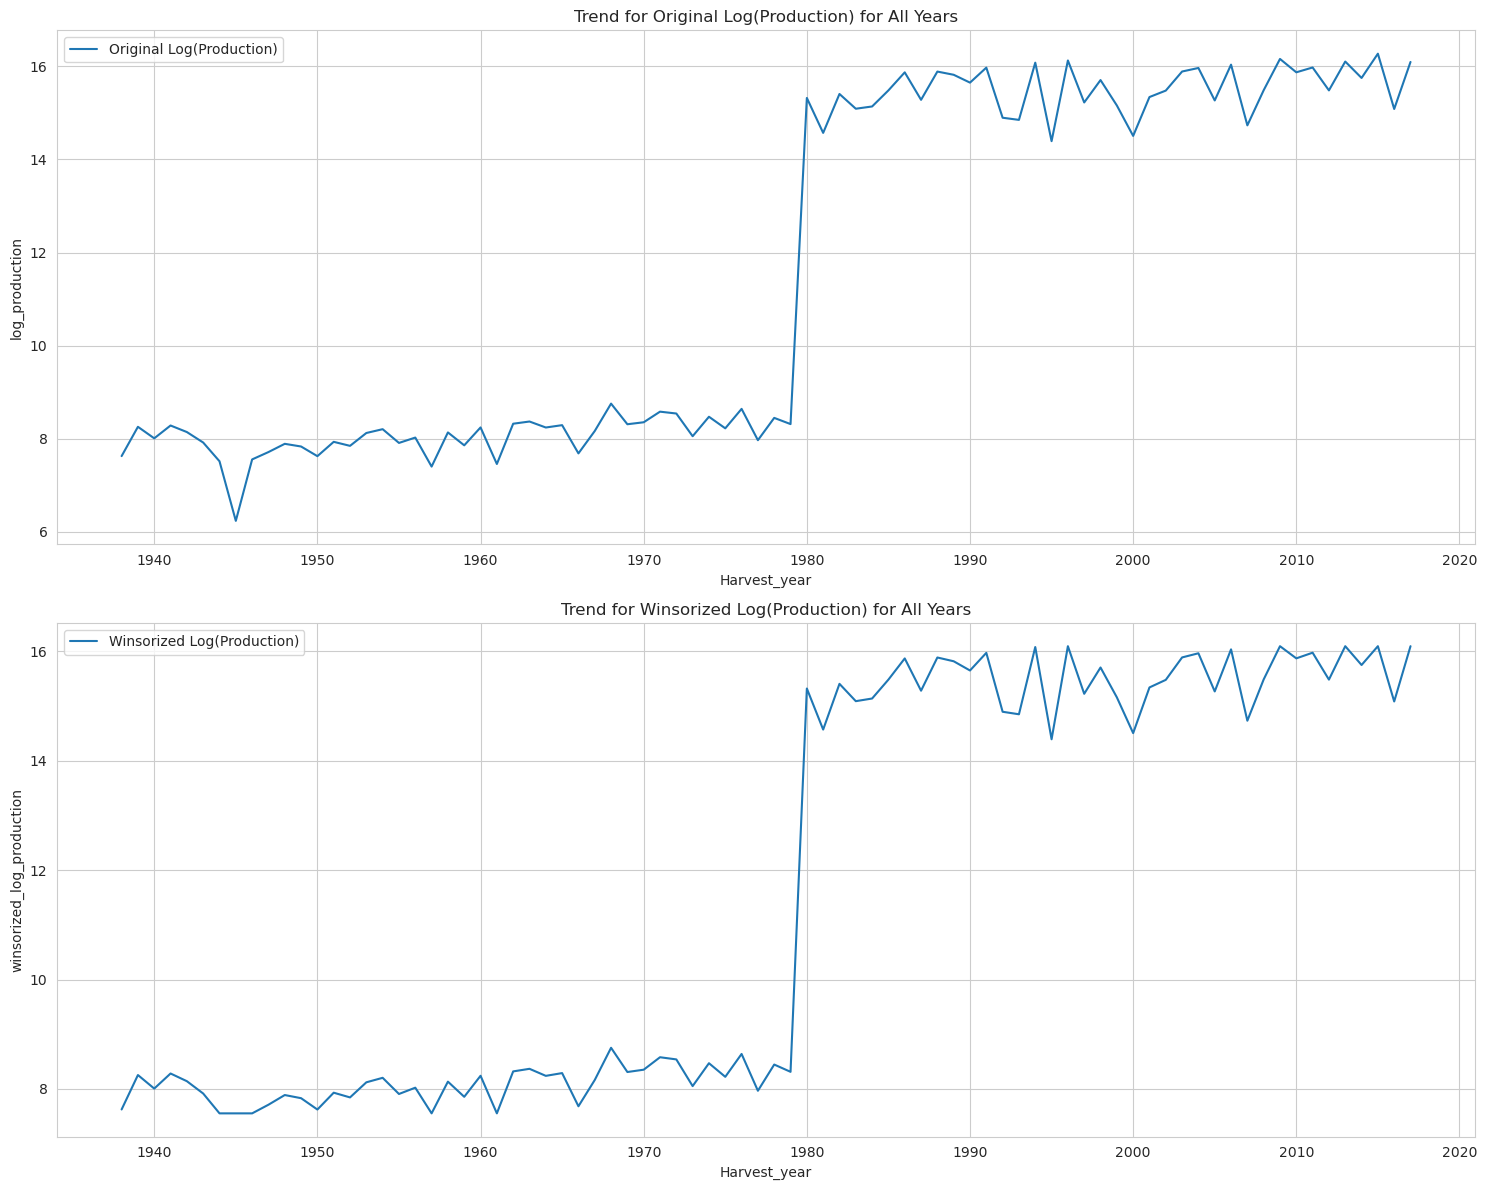

In [92]:
#Winsorize the 'log(production)' values for pre-1980 data at the 5th and 95th percentiles

pre_1980_data['winsorized_log_production'] = mstats.winsorize(pre_1980_data['log_production'], limits=[0.05, 0.05])

# Winsorize the 'log(production)' values for the entire dataset at the 5th and 95th percentiles
cropstats_cereals_df['winsorized_log_production'] = mstats.winsorize(cropstats_cereals_df['log_production'], limits=[0.05, 0.05])

# Visualize the original and winsorized log(production) values for the entire dataset
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Original log(production) values for all years
sns.lineplot(x=cropstats_cereals_df['Harvest_year'], y=cropstats_cereals_df['log_production'], ax=ax[0], label='Original Log(Production)')
ax[0].set_title('Trend for Original Log(Production) for All Years')
ax[0].legend()

# Winsorized log(production) values for all years
sns.lineplot(x=cropstats_cereals_df['Harvest_year'], y=cropstats_cereals_df['winsorized_log_production'], ax=ax[1], label='Winsorized Log(Production)')
ax[1].set_title('Trend for Winsorized Log(Production) for All Years')
ax[1].legend()

plt.tight_layout()
plt.show()

The visualizations depict the trends for both the original and winsorized `log(production)` values for all years:

**Top Chart (Original Log(Production) for All Years)**: This line chart showcases the trend for the original log(production) values over all years. The outliers, including the one in 1945, are visible.

**Bottom Chart (Winsorized Log(Production) for All Years)**: This line chart displays the trend for the winsorized log(production) values over all years. The extreme values, including the one from 1945, have been capped, making the data smoother.

The winsorization has successfully handled the outliers, ensuring a more consistent representation of the data.

## 13. Dropping Redundant Columns and Saving the file

In [93]:
# Drop the specified columns from the filled dataset
columns_to_drop = [
    'mod_z_score_hectares', 
    'mod_z_score_production', 
    'calculated_yield', 
    'winsorized_yield', 
    'log_production', 
    'winsorized_log_production'
]

# Dropping the columns
complete_data_cleaned = cropstats_cereals_df.drop(columns=columns_to_drop)

cropstats_cereals_df = complete_data_cleaned

In [95]:
cropstats_cereals_df.to_csv('Cereal.csv')